In [1]:
import numpy as np
import h5py
import time
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from py_files.basic_functions import getting_2D_data_from_h5_filtered_np_xy_switched_without_intensity_filter, getting_2D_data_from_h5_including_points_without_lasing

In [2]:
class layer: 
    main_name = 'Parameterentwicklung'
    h5_path = '/home/jan/Documents/IWU/Parameterentwicklung.h5'
    
    def __init__(self, number, part):
        self.number = number 
        self.part = part
    
    # function for getting the array without the points with area and intensity = 0
    def array(self):
        return getting_2D_data_from_h5_filtered_np_xy_switched_without_intensity_filter(self.h5_path, self.main_name, self.part, 'Slice'+str("{:05}".format(self.number)))
    
    # function for getting the array including the points with area and intensity = 0 
    def array_wo_lasing(self):
        return getting_2D_data_from_h5_including_points_without_lasing(self.h5_path, self.main_name, self.part, 'Slice'+str("{:05}".format(self.number)))

In [3]:
def vector_dataframe(layer_number,  part_name,  ref_len,  diff_angle,  frequency):
    
    # inputs:
    # - layer_number (int)   - number of the layer of interest 
    # - part_name (str)      - name of the part of interest
    # - ref_len (float)      - reference length for deciding whether a vector is a jump or a write vector
    # - diff_angle (float)   - difference angle ''
    # - frequency (float)    - frequency of the monitoring system 
    
    # outputs:
    # - df_ref_points (pd.dataframe) - pandas dataframe containing all the relevant vectors 
    
    # initial values for the comparison (see block ...)
    sab_old = True
    len_crit_old = False
    
    
    # block 1: 
    layer_1 = layer(layer_number, part_name)
    array = layer_1.array_wo_lasing()
    
    zero_array = np.zeros((array.shape[0],14)) # adding zero columns to the data frame for the following calculations 
    new_array = np.append(array,zero_array,axis=1) # appending the zero array to the qmm array 
   
    # iterating through array
    # calculating the x and y difference of following points, the length and the angle of the connecting vector
   
    i = 1
    ref_len=13
    diff_angle=8
    ref_angle = 0
    sab_old = True
    len_crit_old = False

    # column naming: 
    # 0:x, 1:y, 2:int, 3:area, 4:next_x, 5:next_y, 6:x_diff, 7:y_diff, 8:length, 9:angle, 10:sab, 11:len_crit
    # 12:sab-1, 13:len_crit-1, 14:sab+1, 15:len_crit+1, 16:status


    for row in new_array:
        try:
            row[4] = new_array[i][0] # next x_value
            row[5] = new_array[i][1] # next y_value
            row[6] = row[4]-row[0] # x_diff
            row[7] = row[5]-row[1] # y_diff

            row[8] = np.sqrt(row[6]*row[6] + row[7]*row[7])  # length
            row[9] = 180/np.pi * np.arctan(row[7]/row[6])    # angle


            sab = (row[9] < (ref_angle+diff_angle) and row[9] > (ref_angle - diff_angle)) # sab and len_crit as bool
            len_crit = row[8] > ref_len

            if sab == True:        # check necessary, because Bool values can't be saved in a numpy ndarray
                row[10] = 1
            if len_crit == True:
                row[11] = 1
            if sab_old == True:
                row[12] = 1
            if len_crit_old == True:
                row[13] = 1

            sab_old = sab
            len_crit_old = len_crit
            ref_angle = row[9]

            i += 1


        except: 
            #print("problem occured at iteration number " + str(i-1))
            continue
    
    
    i = 1 # i is reset for the next iteration round 
    
   
    for row in new_array:
        try:
            
            # filling the columns of sab+1 and len_crit+1
            row[14] = new_array[i][10] # next sab value
            row[15] = new_array[i][11] # next len_crit_value 

            # performing the checks to decide the status of a certain vector 
            # resetting the values before every iteration 
            sab = False
            length = False
            sab_p = False
            length_p = False
            sab_m = False
            length_m = False


            if row[10] == 1.:
                sab = True
            if row[11] == 1.:
                length = True
            if row[14] == 1.:
                sab_p = True
            if row[15] == 1.:
                length_p = True
            if row[12] == 1.:
                sab_m = True
            if row[13] == 1.:
                length_m = True

            # for a description of the different cases see truth table in scratchbook from Jan 
            if(
               (sab == 0 and length == 0 and sab_m == 0 and length_m == 0 and sab_p == 1 and length_p ==0) or
               (sab == 0 and length == 0 and sab_m == 0 and length_m == 1 and sab_p == 1 and length_p ==0) or
               #(sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 1 and length_p ==0) or
               (sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p ==0) or 
               (sab == 0 and length == 0 and sab_m == 1 and length_m == 1 and sab_p == 1 and length_p ==0)):

                status = 1 #"scan"

            elif((sab == 0 and length == 0 and sab_m == 0 and length_m == 1 and sab_p == 0 and length_p ==0) or
               (sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 0 and length_m == 0 and sab_p == 0 and length_p == 0) or
               (sab == 0 and length == 1 and sab_m == 0 and length_m == 1 and sab_p == 0 and length_p == 0) or
               (sab == 0 and length == 1 and sab_m == 0 and length_m == 1 and sab_p == 1 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 1 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 1 and length_m == 1 and sab_p == 0 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 0) ):

                status = 2 #"jump"

            else:
                status = 0 #"nd"

            row[16] = status  

            i += 1

        except:
            #print("problem occured at iteration number " + str(i-1))
            continue
            
            
    # transforming the array to a pandas dataframe         
    df = pd.DataFrame(data=new_array, columns=["x", "y","int","area", "x_next", "y_next", "x_diff", "y_diff", "length", "angle", "sab", "len_crit",
        "sab-1", "len_crit-1", "sab+1", "len_crit+1", "status","speed"] )
    
    
    # block 5: the Scan and Jump vectors are extracted from the big dataframe
    
    df_ref_points = df[(df['status'] != 0)]
    df_ref_points = df_ref_points.reset_index()
    
        
    # block 6: New values for the length and angle columns are calculated for the small dataframe 
    
    for index,row in tqdm(df_ref_points.iterrows()):
        if index < (len(df_ref_points)-1):
            x_diff = df_ref_points['x'][index+1] - df_ref_points['x'][index]
            y_diff = df_ref_points['y'][index+1] - df_ref_points['y'][index]
            length = np.sqrt(x_diff*x_diff + y_diff*y_diff)
            angle = 180/np.pi * np.arctan(y_diff/x_diff)

            df_ref_points['x_diff'][index] = x_diff
            df_ref_points['y_diff'][index]= y_diff
            df_ref_points['length'][index] = length
            df_ref_points['angle'][index]  = angle  
                  
    # block 7: based on the frequency of the monitoring system and the distances scanning speeds are calculated and added 
    
    for index,row in tqdm(df_ref_points.iterrows()):

        try:
            time = (df_ref_points["index"][index+1] - df_ref_points["index"][index])*frequency # in seconds
            length = df_ref_points["length"][index]* (1/0.252) * 0.001 # (1/0.252 für transforming the Bit in µm amd 0.001 für tranforming µm to mm ) 

            speed = int(length/time) # in mm/s

            df_ref_points["speed"][index] = speed
            
        except:
            continue
                        
    return df_ref_points

In [4]:
# Ziel: alle Teile aus HDF5 bekommen

h5_path = '/home/jan/Documents/IWU/Parameterentwicklung.h5'

with h5py.File(h5_path, 'r') as h5:
    name_list = list(h5['Parameterentwicklung'].keys()) 

In [69]:
df_1 = vector_dataframe(4, part_name = "W60_H100", ref_len = 13, diff_angle = 8, frequency = (1/40000))
df_2 = vector_dataframe(4, part_name = "W60_H101", ref_len = 13, diff_angle = 8, frequency = (1/40000))

/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
0it [00:00, ?it/s]/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

In [11]:
vectors_combined = pd.DataFrame(columns=["index","x", "y","int","area", "x_next", "y_next", "x_diff", "y_diff", "length", "angle", "sab", "len_crit","sab-1", "len_crit-1", "sab+1", "len_crit+1", "status","speed"])

for element in name_list:#[:30]:
    print(element)
    df = vector_dataframe(200, part_name = element, ref_len = 13, diff_angle = 8, frequency = (1/40000))
    vectors_combined = vectors_combined.append(df)

W60_H100


/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
0it [00:00, ?it/s]/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

W60_H101


361it [00:00, 3281.07it/s]
361it [00:00, 6738.48it/s]


W60_H102


363it [00:00, 3211.38it/s]
363it [00:00, 7287.91it/s]


W60_H103


372it [00:00, 3277.21it/s]
372it [00:00, 6863.33it/s]


W60_H104


361it [00:00, 3129.57it/s]
361it [00:00, 7078.75it/s]


W60_H105


343it [00:00, 3433.11it/s]
343it [00:00, 7279.35it/s]


W60_H106


355it [00:00, 3202.41it/s]
355it [00:00, 6345.09it/s]


W60_H107


355it [00:00, 3151.90it/s]
355it [00:00, 6305.65it/s]


W60_H108


339it [00:00, 3112.82it/s]
339it [00:00, 7203.90it/s]


W60_H109


337it [00:00, 3467.12it/s]
337it [00:00, 7049.74it/s]


W60_H110


334it [00:00, 3115.84it/s]
334it [00:00, 6920.10it/s]


W60_H111


371it [00:00, 2748.02it/s]
371it [00:00, 4382.27it/s]


W60_H112


335it [00:00, 3250.86it/s]
335it [00:00, 7277.48it/s]


W60_H113


325it [00:00, 3162.38it/s]
325it [00:00, 6753.21it/s]


W60_H114


333it [00:00, 3207.48it/s]
333it [00:00, 6968.01it/s]


W60_H115


324it [00:00, 2843.95it/s]
324it [00:00, 6278.90it/s]


W60_H116


320it [00:00, 2656.74it/s]
320it [00:00, 5655.25it/s]


W60_H117


324it [00:00, 3132.95it/s]
324it [00:00, 7038.26it/s]


W60_H118


294it [00:00, 2088.54it/s]
294it [00:00, 3809.51it/s]


W60_H119


313it [00:00, 3288.70it/s]
313it [00:00, 7360.86it/s]


W60_H120


303it [00:00, 3248.90it/s]
303it [00:00, 7138.90it/s]


W60_H121


319it [00:00, 3279.14it/s]
319it [00:00, 7324.79it/s]


W60_H122


348it [00:00, 3255.02it/s]
348it [00:00, 7232.96it/s]


W60_H123


309it [00:00, 3260.34it/s]
309it [00:00, 7108.13it/s]


W60_H124


270it [00:00, 3027.40it/s]
270it [00:00, 6888.08it/s]


W60_H125


274it [00:00, 3259.19it/s]
274it [00:00, 7339.02it/s]


W60_H126


291it [00:00, 3297.11it/s]
291it [00:00, 7074.34it/s]


W60_H127


293it [00:00, 3233.64it/s]
293it [00:00, 7194.89it/s]


W60_H128


315it [00:00, 3394.04it/s]
315it [00:00, 7254.55it/s]


W60_H129


289it [00:00, 3299.56it/s]
289it [00:00, 7215.67it/s]


W60_H130


283it [00:00, 3164.31it/s]
283it [00:00, 6602.48it/s]


W60_H131


286it [00:00, 3270.39it/s]
286it [00:00, 7021.03it/s]


W60_H132


291it [00:00, 3287.88it/s]
291it [00:00, 7092.55it/s]


W60_H133


325it [00:00, 3256.31it/s]
325it [00:00, 7017.93it/s]


W60_H134


275it [00:00, 3217.90it/s]
275it [00:00, 7250.56it/s]


W60_H135


272it [00:00, 3223.41it/s]
272it [00:00, 7049.21it/s]


W60_H136


270it [00:00, 3212.50it/s]
270it [00:00, 7034.36it/s]


W60_H137


274it [00:00, 3293.32it/s]
274it [00:00, 7106.57it/s]


W60_H138


262it [00:00, 3240.69it/s]
262it [00:00, 7321.90it/s]


W60_H139


284it [00:00, 3440.84it/s]
284it [00:00, 7303.92it/s]


W60_H140


290it [00:00, 3446.59it/s]
290it [00:00, 6929.50it/s]


W60_H141


288it [00:00, 3468.89it/s]
288it [00:00, 6982.55it/s]


W60_H142


313it [00:00, 3300.13it/s]
313it [00:00, 7272.14it/s]


W60_H143


265it [00:00, 3319.81it/s]
265it [00:00, 7247.73it/s]


W60_H144


324it [00:00, 3195.86it/s]
324it [00:00, 7099.56it/s]


W60_H145


279it [00:00, 3311.68it/s]
279it [00:00, 7380.52it/s]


W60_H146


279it [00:00, 3444.63it/s]
279it [00:00, 7211.10it/s]


W60_H147


286it [00:00, 3255.08it/s]
286it [00:00, 7240.77it/s]


W60_H148


256it [00:00, 3491.85it/s]
256it [00:00, 7157.32it/s]


W60_H149


273it [00:00, 3226.87it/s]
273it [00:00, 7164.91it/s]


W60_H150


272it [00:00, 3438.95it/s]
272it [00:00, 7436.56it/s]


W60_H151


262it [00:00, 3423.59it/s]
262it [00:00, 6746.94it/s]


W60_H152


254it [00:00, 3450.53it/s]
254it [00:00, 6508.32it/s]


W60_H153


265it [00:00, 3246.62it/s]
265it [00:00, 7389.20it/s]


W60_H154


258it [00:00, 3330.79it/s]
258it [00:00, 7483.51it/s]


W60_H155


298it [00:00, 3296.94it/s]
298it [00:00, 7026.42it/s]


W60_H156


236it [00:00, 3270.35it/s]
236it [00:00, 7290.47it/s]


W60_H157


237it [00:00, 3494.18it/s]
237it [00:00, 7620.75it/s]


W60_H158


254it [00:00, 3481.79it/s]
254it [00:00, 7505.82it/s]


W60_H159


256it [00:00, 3315.14it/s]
256it [00:00, 7362.46it/s]


W60_H160


247it [00:00, 3260.72it/s]
247it [00:00, 7254.50it/s]


W60_H161


254it [00:00, 3427.45it/s]
254it [00:00, 7405.28it/s]


W60_H162


246it [00:00, 3431.93it/s]
246it [00:00, 7430.12it/s]


W60_H163


251it [00:00, 3475.93it/s]
251it [00:00, 6925.21it/s]


W60_H164


250it [00:00, 3305.09it/s]
250it [00:00, 7275.31it/s]


W60_H165


249it [00:00, 3212.81it/s]
249it [00:00, 7369.44it/s]


In [12]:
vectors_combined

,index,x,y,int,area,x_next,y_next,x_diff,y_diff,length,angle,sab,len_crit,sab-1,len_crit-1,sab+1,len_crit+1,status,speed
0,0,12743.0,-3517.0,0.0,0.0,12732.0,-3535.0,-7684.0,-12318.0,14518.160352,58.043979,0.0,1.0,1.0,0.0,1.0,1.0,2.0,4205.0
1,548,5059.0,-15835.0,0.0,0.0,5088.0,-15822.0,29.0,13.0,31.780497,24.145542,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5044.0
2,549,5088.0,-15822.0,0.0,0.0,5099.0,-15821.0,11.0,1.0,11.045361,5.194429,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1753.0
3,550,5099.0,-15821.0,0.0,0.0,5094.0,-15826.0,-43.0,-43.0,60.811183,45.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1378.0
4,557,5056.0,-15864.0,0.0,794.0,5055.0,-15877.0,-1.0,-13.0,13.038405,85.601295,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2069.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,17632,24821.0,15834.0,0.0,0.0,21603.0,17114.0,-2360.0,-848.0,2507.728853,19.764481,0.0,1.0,1.0,1.0,0.0,1.0,2.0,3864.0
245,17735,22461.0,14986.0,0.0,0.0,22791.0,15315.0,1896.0,1896.0,2681.348914,45.000000,0.0,1.0,0.0,1.0,1.0,1.0,2.0,212805.0
246,17737,24357.0,16882.0,0.0,906.0,24376.0,16842.0,374.0,-1090.0,1152.378410,-71.061918,0.0,1.0,1.0,1.0,0.0,1.0,2.0,3658.0
247,17787,24731.0,15792.0,0.0,988.0,24841.0,15843.0,110.0,51.0,121.247680,24.874154,0.0,1.0,0.0,1.0,0.0,0.0,2.0,19245.0


In [13]:
vectors_combined = vectors_combined.reset_index()

for index,row in tqdm(vectors_combined.iterrows()):
    if index < (len(vectors_combined)-1):
        x_diff = vectors_combined['x'][index+1] - vectors_combined['x'][index]
        y_diff = vectors_combined['y'][index+1] - vectors_combined['y'][index]
        length = np.sqrt(x_diff*x_diff + y_diff*y_diff)
        angle = 180/np.pi * np.arctan(y_diff/x_diff)
        
        vectors_combined['x_diff'][index] = x_diff
        vectors_combined['y_diff'][index]= y_diff
        vectors_combined['length'][index] = length
        vectors_combined['angle'][index]  = angle   

0it [00:00, ?it/s]/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

In [14]:
vectors_combined

,level_0,index,x,y,int,area,x_next,y_next,x_diff,y_diff,length,angle,sab,len_crit,sab-1,len_crit-1,sab+1,len_crit+1,status,speed
0,0,0,12743.0,-3517.0,0.0,0.0,12732.0,-3535.0,-7684.0,-12318.0,14518.160352,58.043979,0.0,1.0,1.0,0.0,1.0,1.0,2.0,4205.0
1,1,548,5059.0,-15835.0,0.0,0.0,5088.0,-15822.0,29.0,13.0,31.780497,24.145542,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5044.0
2,2,549,5088.0,-15822.0,0.0,0.0,5099.0,-15821.0,11.0,1.0,11.045361,5.194429,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1753.0
3,3,550,5099.0,-15821.0,0.0,0.0,5094.0,-15826.0,-43.0,-43.0,60.811183,45.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1378.0
4,4,557,5056.0,-15864.0,0.0,794.0,5055.0,-15877.0,-1.0,-13.0,13.038405,85.601295,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2069.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19599,244,17632,24821.0,15834.0,0.0,0.0,21603.0,17114.0,-2360.0,-848.0,2507.728853,19.764481,0.0,1.0,1.0,1.0,0.0,1.0,2.0,3864.0
19600,245,17735,22461.0,14986.0,0.0,0.0,22791.0,15315.0,1896.0,1896.0,2681.348914,45.000000,0.0,1.0,0.0,1.0,1.0,1.0,2.0,212805.0
19601,246,17737,24357.0,16882.0,0.0,906.0,24376.0,16842.0,374.0,-1090.0,1152.378410,-71.061918,0.0,1.0,1.0,1.0,0.0,1.0,2.0,3658.0
19602,247,17787,24731.0,15792.0,0.0,988.0,24841.0,15843.0,110.0,51.0,121.247680,24.874154,0.0,1.0,0.0,1.0,0.0,0.0,2.0,19245.0


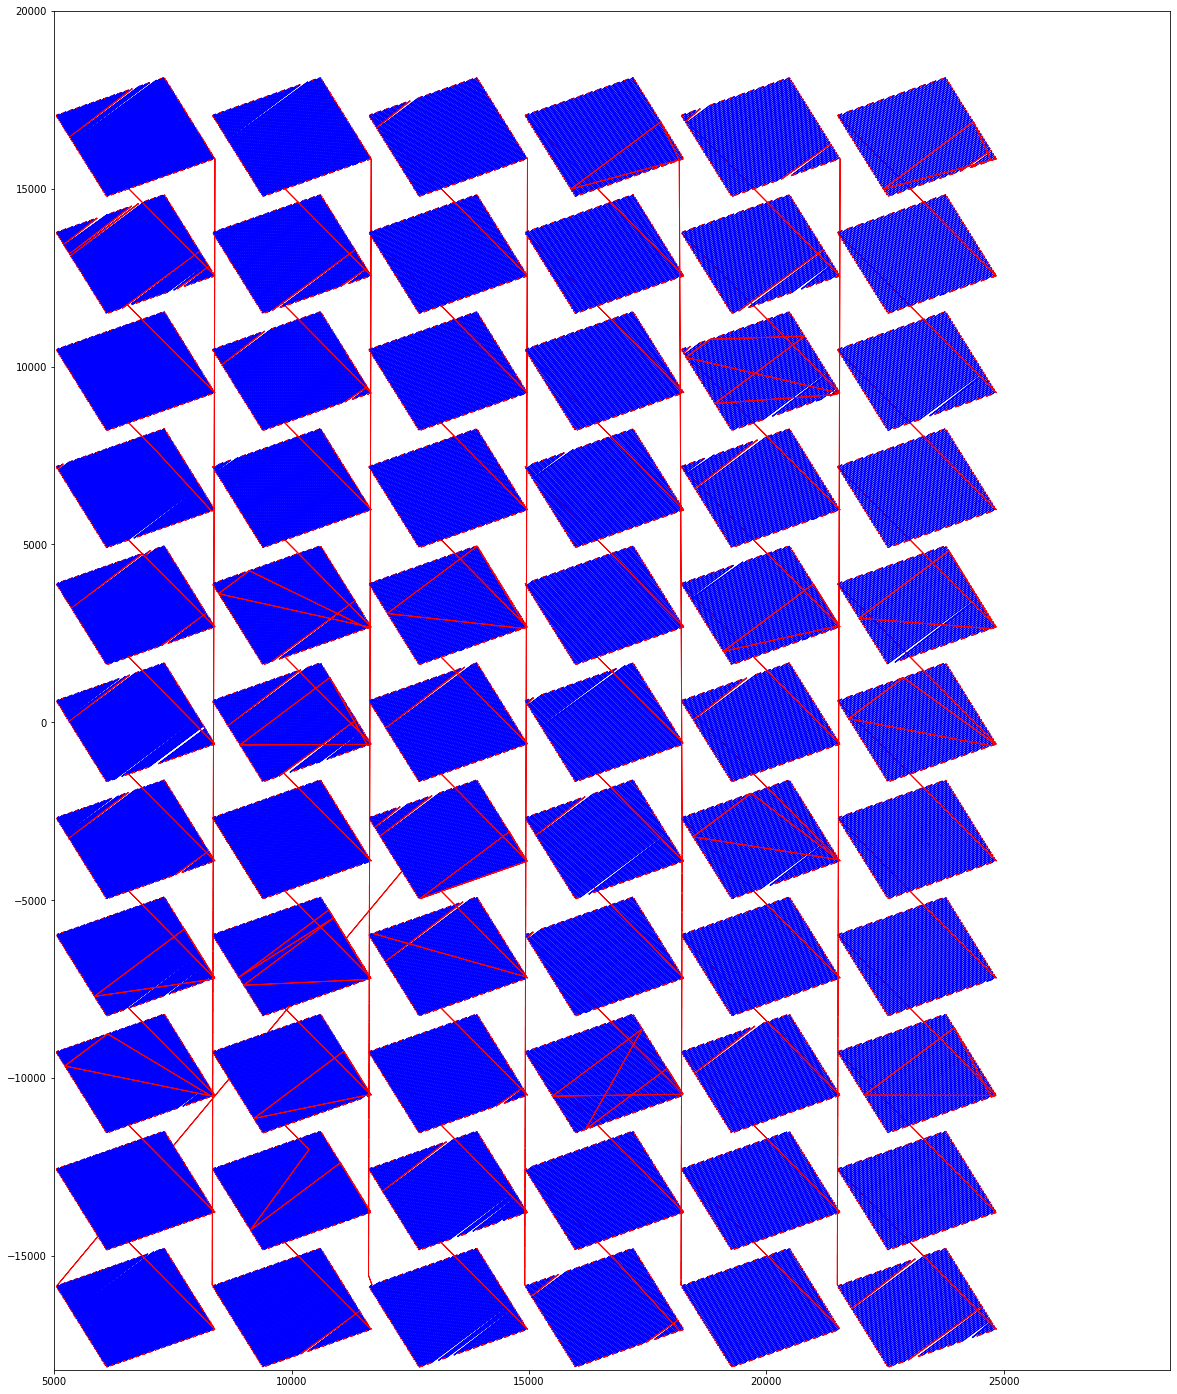

In [15]:
fig, ax = plt.subplots(figsize=(20,25))

for i in range(19604):    #(len(df_turn)):   
    x_pos = vectors_combined['x'][i]
    y_pos = vectors_combined['y'][i]
    x_direct = vectors_combined['x_diff'][i]
    y_direct = vectors_combined['y_diff'][i]
    if vectors_combined['status'][i] == 1:
        color = 'b'
    else: 
        color = 'r'
    
    ax.arrow(x_pos,y_pos,x_direct,y_direct, head_width= 5, head_length= 15, fc='r', ec=color,length_includes_head = True)
    ax.axis([5000, 28500, -18200, 20000])
    
    
    #ax.scatter(x_pos,y_pos, s = 10)   
        
plt.show()

In [3]:
# depricated dataframe version of the problem 


def vector_dataframe(layer_number,  part_name,  ref_len,  diff_angle,  frequency):
    
    # inputs:
    # - layer_number (int)   - number of the layer of interest 
    # - part_name (str)      - name of the part of interest
    # - ref_len (float)      - reference length for deciding whether a vector is a jump or a write vector
    # - diff_angle (float)   - difference angle ''
    # - frequency (float)    - frequency of the monitoring system 
    
    # outputs:
    # - df_ref_points (pd.dataframe) - pandas dataframe containing all the relevant vectors 
    
    # initial values for the comparison (see block ...)
    sab_old = True
    len_crit_old = False
    
    
    # block 1: getting the array and tranforming it into a dataframe, calculating vector length and the vector angle
    
    print("start of block 1")
    layer_1 = layer(layer_number, part_name)
    array = layer_1.array_wo_lasing()
    
    df_raw = pd.DataFrame(columns=['number', 'x', 'y', 'x_end', 'y_end', 'x_diff', 'y_diff', 'length', 'angle','sab','len','sab-1','len-1','sab+1','len+1','status','speed'])

    for i in tqdm(range(len(array)-1)):
        x_diff = array[i+1][0]-array[i][0]
        y_diff = array[i+1][1]-array[i][1]
        length = np.sqrt(x_diff*x_diff + y_diff*y_diff)
        angle = 180/np.pi * np.arctan(y_diff/x_diff)
        df_raw = df_raw.append(
            {'number': i, 'x': array[i][0], 'y': array[i][1], 'x_end': array[i+1][0], 'y_end': array[i+1][1], 'x_diff': x_diff, 'y_diff':y_diff, 'length':length, 'angle':angle}, ignore_index=True)

    print("end of block 1")

    # block 2: based on the angle and length values the sab ('(angle) Same As Before') and len (length > ref_len) are filled
    #          Furthermore in seperate columns (sab-1 and len-1) the values of the previous vector are stored
    
    ref_angle = 0
           
    for index,row in tqdm(df_raw.iterrows()):
        #print(row['angle'])
        sab = (row['angle'] < (ref_angle + diff_angle) and row['angle'] > (ref_angle - diff_angle))
        len_crit = row['length'] > ref_len # len_crit becomes True if the vector is longer than the reference one

        df_raw['sab'][index] = sab
        df_raw['len'][index] = len_crit
        df_raw['sab-1'][index] = sab_old
        df_raw['len-1'][index] = len_crit_old  

        sab_old = sab
        len_crit_old = len_crit
        ref_angle = row['angle']
        
    print("end of block 2")

    
    # block 3: In the columns (sab+1) and (len+1) the values of the following vectors are stored
    
    for index,row in tqdm(df_raw.iterrows()):
        try:
            df_raw['sab+1'][index] = df_raw['sab'][index+1]
            df_raw['len+1'][index] = df_raw['len'][index+1]
        except:
            continue
        
    print("end of block 3")
        

    # block 4: Based on different conditions it is decided whether a vector is a "Scan" or a "Jump" vector.  
    
    for index,row in tqdm(df_raw.iterrows()):
        sab = df_raw['sab'][index]
        length = df_raw['len'][index]
        sab_p = df_raw['sab+1'][index]
        length_p = df_raw['len+1'][index]
        sab_m = df_raw['sab-1'][index]
        length_m = df_raw['len-1'][index]

        # for a description of the different cases see truth table in scratchbook from Jan 
        if(
           (sab == 0 and length == 0 and sab_m == 0 and length_m == 0 and sab_p == 1 and length_p ==0) or
           (sab == 0 and length == 0 and sab_m == 0 and length_m == 1 and sab_p == 1 and length_p ==0) or
           #(sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 1 and length_p ==0) or
           (sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p ==0) or 
           (sab == 0 and length == 0 and sab_m == 1 and length_m == 1 and sab_p == 1 and length_p ==0)):

            status = "scan"

        elif((sab == 0 and length == 0 and sab_m == 0 and length_m == 1 and sab_p == 0 and length_p ==0) or
           (sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 1) or
           (sab == 0 and length == 1 and sab_m == 0 and length_m == 0 and sab_p == 0 and length_p == 0) or
           (sab == 0 and length == 1 and sab_m == 0 and length_m == 1 and sab_p == 0 and length_p == 0) or
           (sab == 0 and length == 1 and sab_m == 0 and length_m == 1 and sab_p == 1 and length_p == 1) or
           (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 1) or
           (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 1 and length_p == 1) or
           (sab == 0 and length == 1 and sab_m == 1 and length_m == 1 and sab_p == 0 and length_p == 1) or
           (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 0) ):

            status = "jump"

        else:
            status = "nd"
 
        df_raw['status'][index] = status
    
    print("end of block 4")

    # block 5: the Scan and Jump vectors are extracted from the big dataframe
    
    df_ref_points = df_raw[(df_raw['status'] != "nd")]
    df_ref_points = df_ref_points.reset_index()
    
    print("end of block 5")

    
    # block 6: New values for the length and angle columns are calculated for the small dataframe 
    
    for index,row in tqdm(df_ref_points.iterrows()):
        if index < (len(df_ref_points)-1):
            x_diff = df_ref_points['x'][index+1] - df_ref_points['x'][index]
            y_diff = df_ref_points['y'][index+1] - df_ref_points['y'][index]
            length = np.sqrt(x_diff*x_diff + y_diff*y_diff)
            angle = 180/np.pi * np.arctan(y_diff/x_diff)

            df_ref_points['x_diff'][index] = x_diff
            df_ref_points['y_diff'][index]= y_diff
            df_ref_points['length'][index] = length
            df_ref_points['angle'][index]  = angle  
            
    print("end of block 6")
      
    # block 7: based on the frequency of the monitoring system and the distances scanning speeds are calculated and added 
    
    for index,row in tqdm(df_ref_points.iterrows()):

        try:
            time = (df_ref_points["number"][index+1] - df_ref_points["number"][index])*frequency # in seconds
            length = df_ref_points["length"][index]* (1/0.252) * 0.001 # (1/0.252 für transforming the Bit in µm amd 0.001 für tranforming µm to mm ) 

            speed = int(length/time) # in mm/s

            df_ref_points["speed"][index] = speed
            
        except:
            continue
            
    print("end of block 7")
            
    return df_ref_points